# Diamond Price Analysis
---
### Authors:
* Marcin Bereźnicki
* Jakub Burczyk
---
### The problem:
The purpose of the project was to analyze diamond's pricing based on it's weight, taking into account its other characteristics such as cut and clarity.

### The goal:
We hope, that after creating sufficient model it will be possible to predict a price for gem given it's weight also taking into account it's clarity and quality of the cut.

It may be possible to estimate a price without any trade specific knowledge, which could prevent getting ripped off by sellers/buyers.

---

# Table of contents
We highly recommend using provided hyperlinks to sections.

* [Dataset](#dataset)
* [Python modules](#imports)
* [Data Tidying](#data-tidying)
  * [Dropping indexes](#dropping-index)
  * [Relevant data extraction](#data-extraction)
  * [Plotting dataset](#plotting-dataset)
  * [Trimming dataset](#trimming-dataset)
* [Data Analysis](#data-analysis)
  * [Loading dataset](#loading-dataset)
  * [Model 1 - two predictors: weight and clarity](#model-1---two-predictors)
    * [Prior predictive check](#model-1---prior-predictive-check)
      * [Comparing priors with data](#model-1---comparing-margin-prior-values-with-data)
    * [Posterior analysis](#model-1---posterior-analysis)
    * [Model parameters](#model-1---model-parameters)
    * [Evaluation](#model-1---evaluation)
      * [Quantiles](#model-1---quantiles)
      * [Predictions and density](#model-1---predictions-and-density-plot)
  * [Model 2 - three predictors: weight, clarity and cut quality](#model-2---three-predictors)
      * [Prior predictive check](#model-2---prior-predictive-check)
        * [Comparing priors with data](#model-2---comparing-margin-prior-values-with-data)
      * [Posterior analysis](#model-2---posterior-analysis)
      * [Model parameters](#model-2---model-parameters)
      * [Evaluation](#model-2---evaluation)
        * [Quantiles](#model-2---quantiles)
        * [Predictions and density](#model-2---predictions-and-density-plot) 
  * [Model Comparison](#model-comparison)
    * [PSIS-LOO Criterion](#psis-loo-criterion)
    * [WAIC Criterion](#waic-criterion)
    * [Conclusions](#model-comparison---conclusions)

---
# Dataset
[***Return to table of contents***](#table-of-contents)

The data was sourced from [Kaggle.com](https://www.kaggle.com/) which is an online community of data scientists. The dataset can be downloaded [**here**](https://www.kaggle.com/datasets/shivam2503/diamonds).

Dataset contains 53 941 records containing description of 10 diamond properties.

The colums are as follows:
* **price** - in US dollars
* **carat** - weight of the gem
* **cut** - quality of the cut
* **color** - gem's color
* **clarity** - measurement how clear the gem is and it's defects
* **x** - length in milimiters
* **y** - width in milimiters
* **z** - depth in milimiters
* **table** width of top face of the diamond relative to widest point
* **depth** - depth percentage 
\begin{equation}
depth = \frac{z}{mean(x,y)}
\end{equation}

---

---
# Imports
[***Return to table of contents***](#table-of-contents)


Necessary python modules for data analysis.

---

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

---
# Data tidying
[***Return to table of contents***](#table-of-contents)

Before starting analysis it may be necessary to clean up the dataset.

---
## Dropping index
[***Return to table of contents***](#table-of-contents)

The first column contians record id without column name, but for our purpouses it is not necessary thus it gets dropped after loading the dataset file.

---

In [2]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


---
## Data extraction
[***Return to table of contents***](#table-of-contents)

For our analysis we will consider up to three variables affecting gem pricing - it's mass, clarity and quality of the cut.

Because the values for clarity and cut quality are presented in descriptive classification, they have to be mapped to numeric classification values for processing.

---

In [3]:
cutRemap = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
clarityRemap = {'I1': 1 , 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
colorRemap = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

df=df.replace({"cut": cutRemap})
df=df.replace({"clarity": clarityRemap})
df=df.replace({"color": colorRemap})

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


---
## Plotting dataset
[***Return to table of contents***](#table-of-contents)

It is important to see the data before commencing analysis, afterall we should check in case it's utter nonsense as demonstrated [**here**](https://cran.r-project.org/web/packages/datasauRus/vignettes/Datasaurus.html).

---

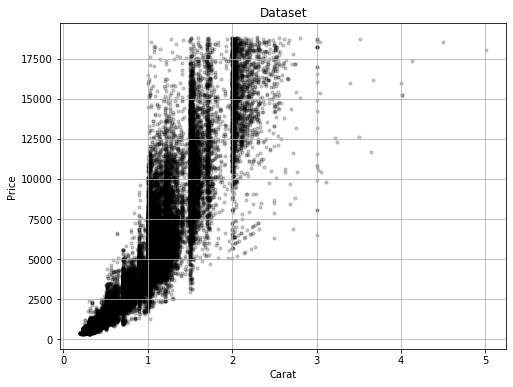

In [4]:
plt.figure(figsize=[8, 6])
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.title('Dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.grid()
plt.show()

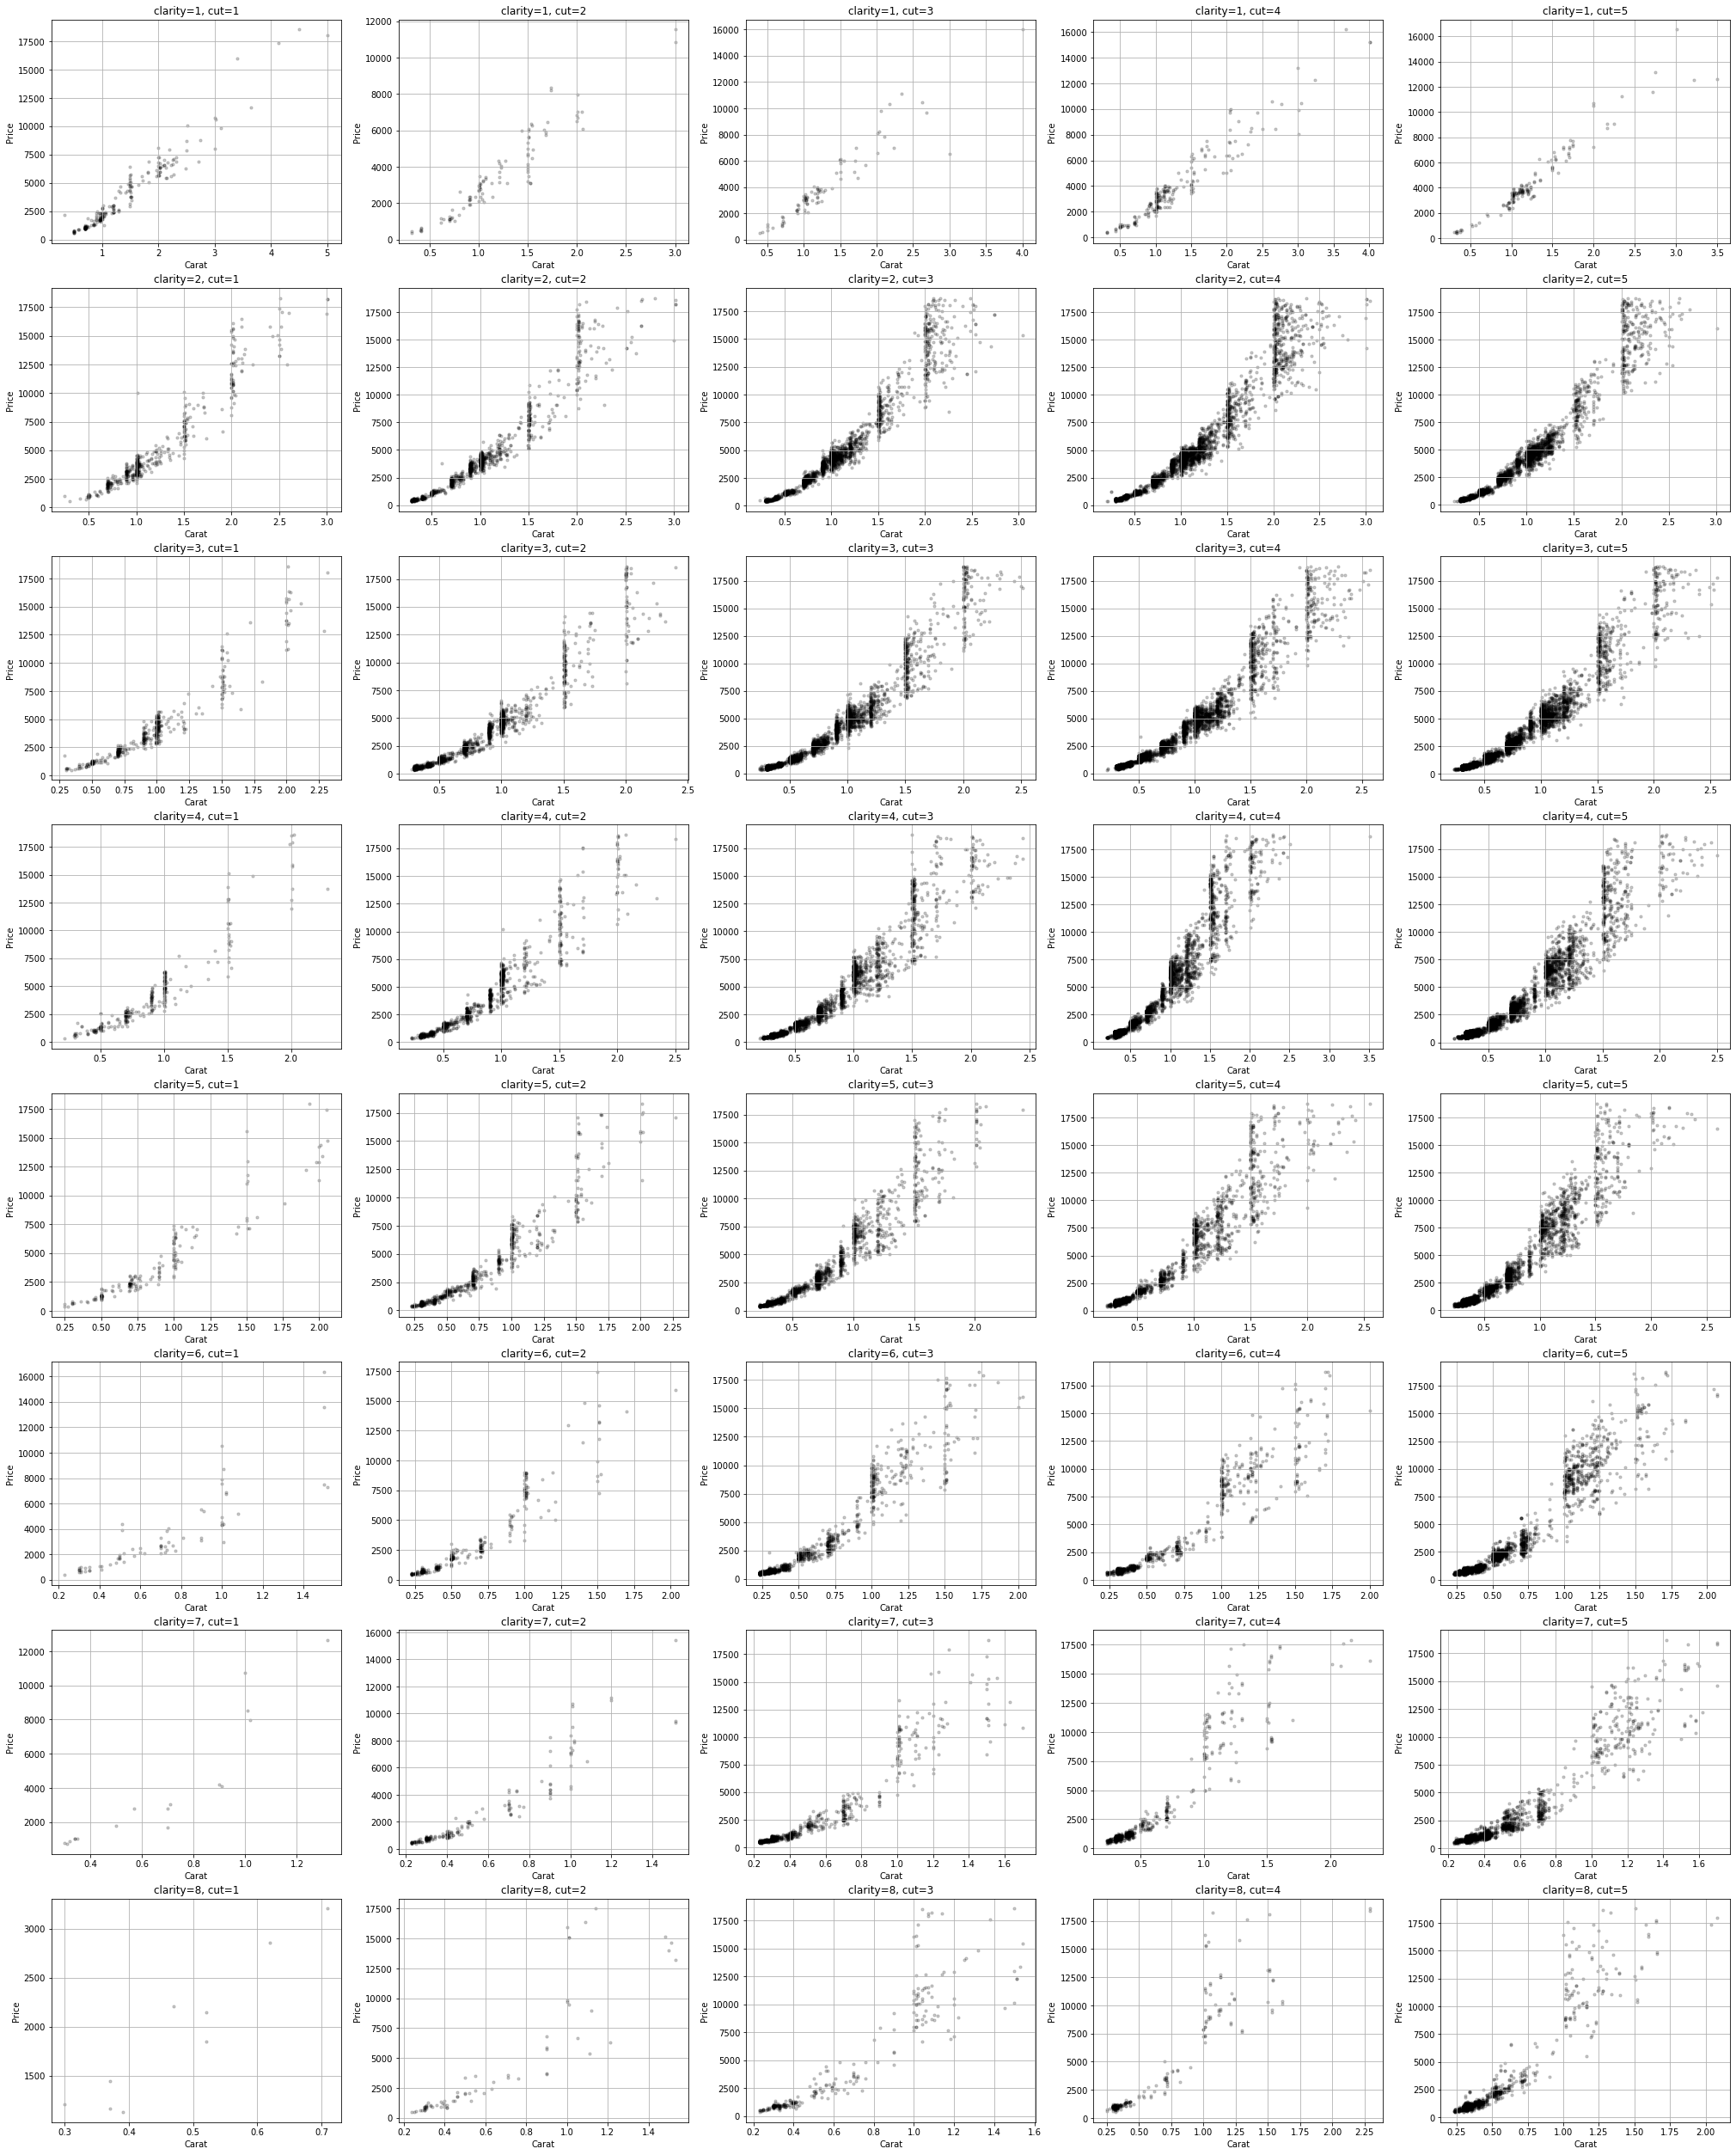

In [5]:
fig, axs = plt.subplots(8,5)
fig.set_size_inches(35, 45)
for i in range(0,8):
    for j in range(0,5):
        df_temp = df.loc[df['clarity'] == i+1]
        df_temp = df_temp.loc[df_temp['cut'] == j+1]
        axs[i][j].scatter(df_temp.carat, df_temp.price, color='black', alpha=0.2, s=10)
        axs[i][j].grid()
        axs[i][j].set_title(f'clarity={i+1}, cut={j+1}')
        axs[i][j].set_xlabel('Carat')
        axs[i][j].set_ylabel('Price')
plt.show()

---
## Trimming dataset
[***Return to table of contents***](#table-of-contents)

The dataset contains a lot of samples which negatively affects model sampling time exponentially. Due to that fact 1000 randoms samples are selected from the entire dataset for further analysis.

---

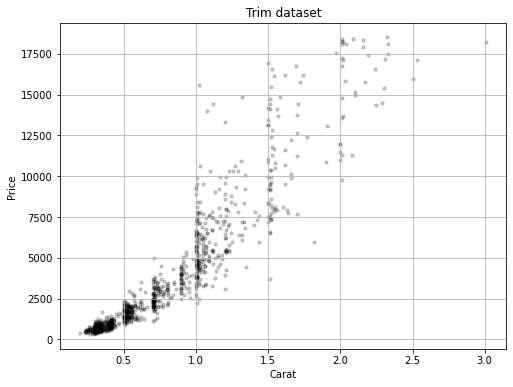

In [6]:
df_trim = df.sample(n = 1000)
df_trim.reset_index(drop=True, inplace=True)

plt.figure(figsize=[8, 6])
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.title('Trim dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.grid()
plt.show()

---
# Data Analysis
[***Return to table of contents***](#table-of-contents)

For analysis we have created 2 bayesian models.

* Model 1 - uses 2 predictors: weight and clarity
* Model 2 - uses 3 predictors: weight, clarity and cut quality

Expanding the first model by increasing the number of predictors allows for a better fit of the model to the observations, in terms of the data, and for value prediction.

The equations, parameters and differences of individual models are presented in the corresponding chapters.

---

---
## Model 1 - two predictors
[***Return to table of contents***](#table-of-contents)

Model has form:

$$ price_i \sim \mathrm{Normal}(\mu_i,\sigma) $$
$$ \mu_i = \alpha_{clarity}[ clarity_i ] + \beta_{clarity}[clarity_i]  * carat_i $$

With parameter distributions set as follows:
$$ \alpha_{clarity} \sim \mathrm{Normal}(-1000, 10) $$
$$ \beta_{clarity} \sim \mathrm{Normal}(10000, 2000) $$
$$ \sigma \sim \mathrm{Exponential}(10) $$

The required input data is the set of diamonds with weight and clarity for which the user wants to make a prediction.

---
### Model 1 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition.

Priors were selected experimentally, starting with small, typical distributions (eg. Normal(0,10)) up to final values based on resultant plot. ( See chapter ["Model 1 - Comparing margin prior values with data"](#model-1---comparing-margin-prior-values-with-data))

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

Based on the shape of obtained cone which contains most of datapoints, it can be concluded that the prior predictive was successful. The obtained lines include points as expected.

#### PPC Model:
![](./images/model_1_ppc.png)

---

In [7]:
model_1_ppc = CmdStanModel(stan_file='stanfiles/model_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'clarity': df_trim.clarity}
model_1_sim = model_1_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


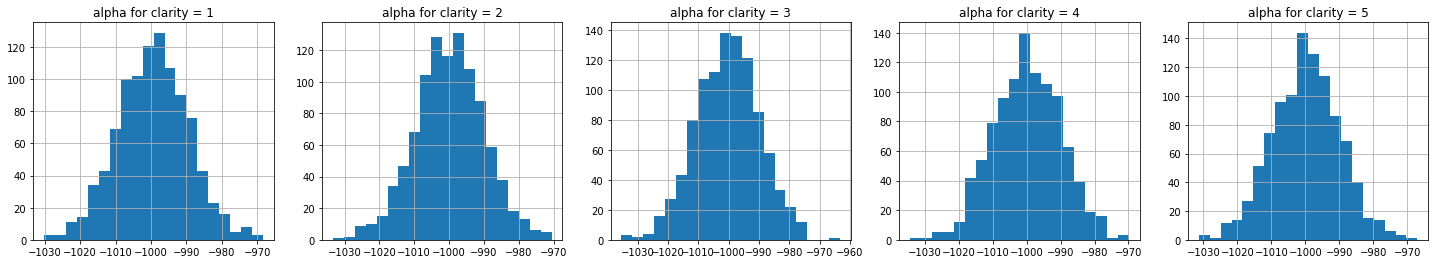

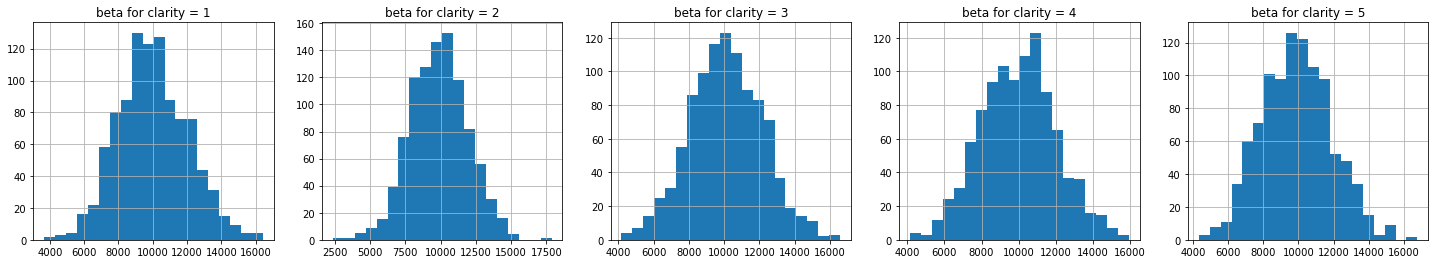

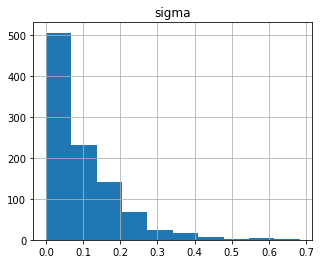

,mean,sd,hdi_3%,hdi_97%
alpha_clarity[0],-999.38,10.00,-1017.91,-980.58
alpha_clarity[1],-999.87,9.83,-1018.40,-981.87
alpha_clarity[2],-1000.26,10.41,-1020.43,-981.08
alpha_clarity[3],-999.88,9.84,-1018.00,-982.33
alpha_clarity[4],-999.79,9.81,-1019.38,-983.02
alpha_clarity[5],-999.83,10.24,-1018.90,-980.53
alpha_clarity[6],-999.73,10.21,-1019.24,-981.66
alpha_clarity[7],-999.60,10.13,-1017.34,-979.50
beta_clarity[0],10011.05,2031.60,6678.41,14201.80
beta_clarity[1],9885.19,2018.80,6403.72,13764.90


In [9]:
alpha_clarity_sim = pd.DataFrame(model_1_sim.stan_variable('alpha_clarity'))
beta_clarity_sim = pd.DataFrame(model_1_sim.stan_variable('beta_clarity'))
sigma_sim = model_1_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_clarity_sim[i], bins=20)
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_clarity_sim[i], bins=20)
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_sim, var_names=['alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

In [10]:
def calcQuants(x, y):
    qlvls = [0, 1]
    quansList = [[], []]
    for i in range(y.shape[-1]):
        temp = y[:, i]
        for q, lvl in zip(quansList, qlvls):
            q.append(np.quantile(temp, lvl))
    return quansList

def quantsExtremes(df, y, q):
    carat_uq = df.carat.unique()
    carat_uq = sorted(carat_uq)
    quansList = calcQuants(df.carat, y)
    caratQuantDict = dict()
    for carat_val in carat_uq:
        caratList = np.array(df.carat.tolist())
        idxs = np.where(caratList == carat_val)[0]
        qval = quansList[q][idxs[0]]
        for i in idxs:
            if q == 0 and quansList[q][i] < qval:
                qval = quansList[q][i]
            elif q == 1 and quansList[q][i] > qval:
                qval = quansList[q][i]
        if q == 0:
            caratQuantDict[carat_val] = qval
        elif q == 1:
            caratQuantDict[carat_val] = qval
    return caratQuantDict

---
### Model 1 - Comparing margin prior values with data
[***Return to table of contents***](#table-of-contents)

---

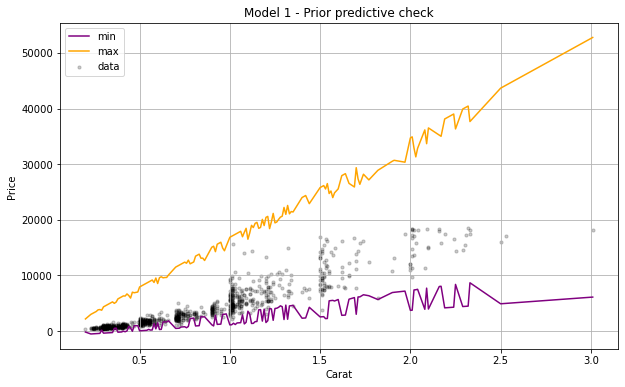

In [11]:
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Prior predictive check")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

Based on the shape of obtained cone which contains most of datapoints, it can be concluded that the prior predictive was successful. The obtained lines include points as expected.

---
### Model 1 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

As mentioned previously sampling time was heavily dependent on number of datapoints, but, according to diagnose result,  no other issues were encountered.

#### First model stan code:

![](./images/model_1.png)

---

In [12]:
model_1 = CmdStanModel(stan_file='stanfiles/model_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_1_fit = model_1.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [14]:
model_1_fit.diagnose()

'Processing csv files: C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_1-20220620203415_1.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_1-20220620203415_2.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_1-20220620203415_3.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_1-20220620203415_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

---

### Model 1 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is indicative of the diamonds in same class being slightly different from one another.
The differences between distributions for each clarity class indicates that each class is modeled differently.

---

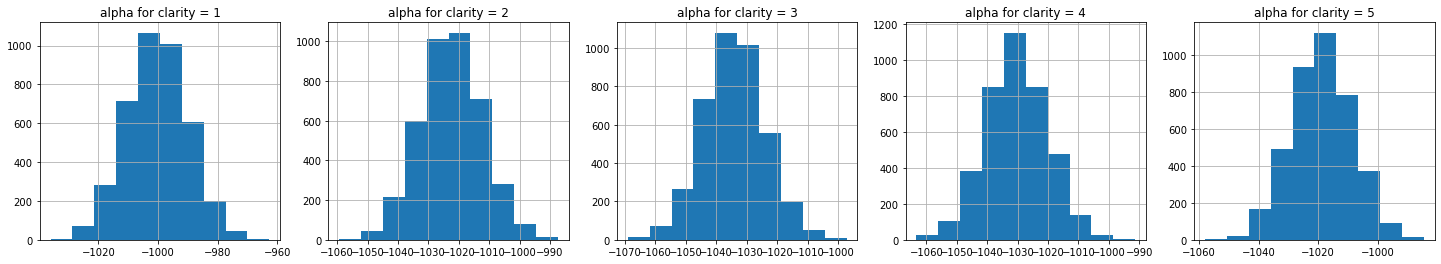

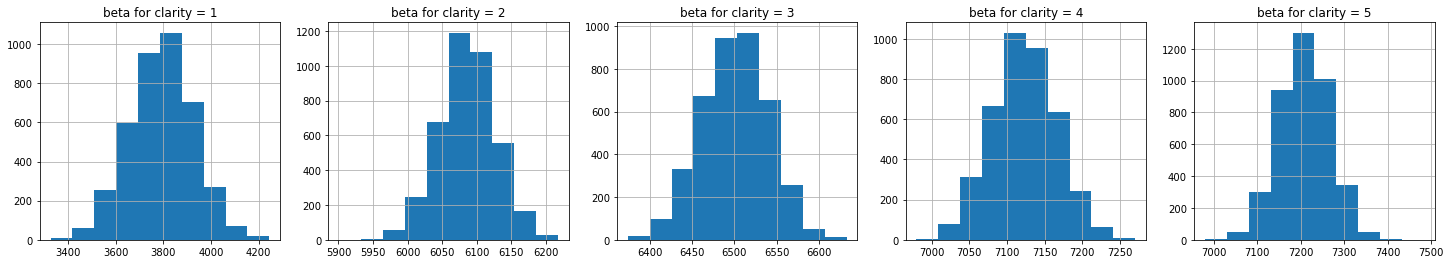

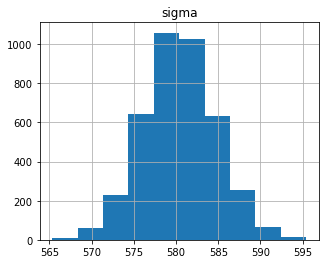

,mean,sd,hdi_3%,hdi_97%
alpha_clarity[0],-1000.31,10.17,-1019.65,-981.64
alpha_clarity[1],-1022.48,10.25,-1041.71,-1003.48
alpha_clarity[2],-1034.13,10.05,-1053.35,-1015.42
alpha_clarity[3],-1030.33,10.04,-1048.97,-1011.39
alpha_clarity[4],-1018.85,10.15,-1037.81,-999.77
alpha_clarity[5],-1008.41,9.89,-1028.40,-991.04
alpha_clarity[6],-1012.93,9.94,-1030.51,-993.68
alpha_clarity[7],-1007.04,10.10,-1025.29,-987.50
beta_clarity[0],3793.29,134.36,3552.86,4050.20
beta_clarity[1],6086.55,40.58,6011.35,6163.95


In [15]:
alpha_clarity_fit = pd.DataFrame(model_1_fit.stan_variable('alpha_clarity'))
beta_clarity_fit = pd.DataFrame(model_1_fit.stan_variable('beta_clarity'))
sigma_fit = model_1_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_clarity_fit[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_clarity_fit[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_fit, var_names=['alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---

### Model 1 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 1 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. Most of the simulated diamonds fall within real data ranges.

---

In [16]:
data = model_1_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+18:len(df_trim)+1018]]
#print(price_sims)

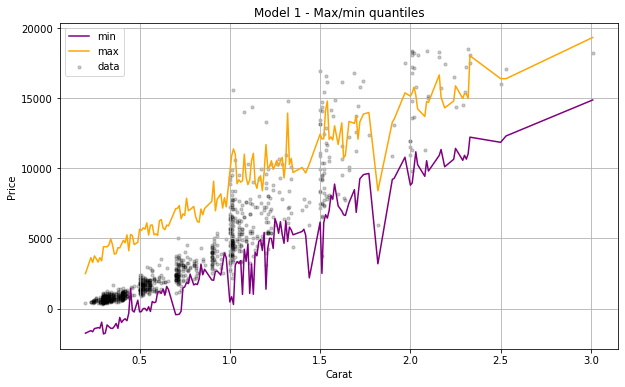

In [17]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Max/min quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

---
#### Model 1 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As seen on the plots the model is somewhat sufficient. It describes most accurately diamonds of weights between 0.75 to 1.75 carats.
It overestimates the deviation of low mass diamonds and underestimates for high weight ones.

Perhaps adding another predictor could solve the issue.

---

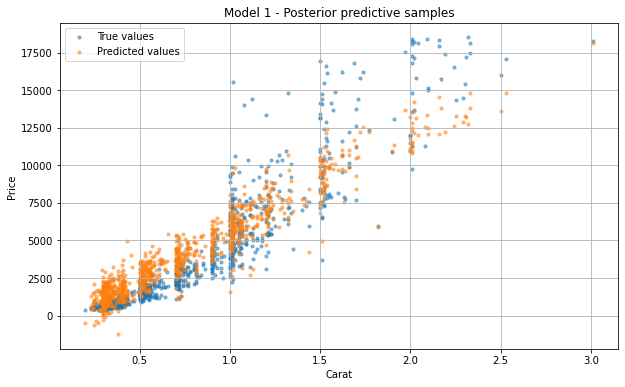

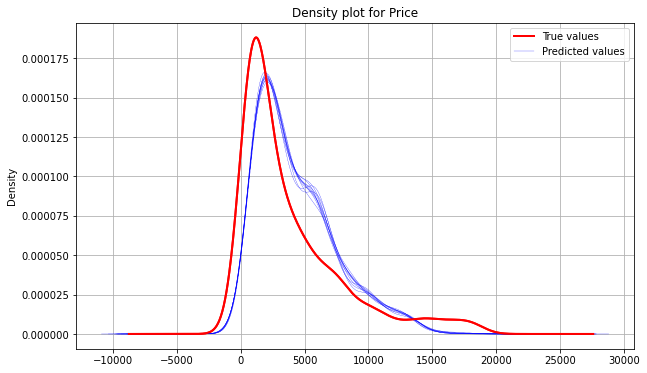

In [18]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[0], alpha=0.5, s=10)
plt.title("Model 1 - Posterior predictive samples")
plt.legend(["True values", "Predicted values"])
plt.xlabel("Carat")
plt.ylabel("Price")
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---
## Model 2 - three predictors
[***Return to table of contents***](#table-of-contents)

Model has form:

$$ price_i \sim \mathrm{Normal}(\mu_i,\sigma) $$
$$ \mu_i =  \alpha_{cut}[ cut_i ] + \alpha_{clarity}[ clarity_i ] + (\beta_{cut}[cut_i] + \beta_{clarity}[clarity_i])  * carat_i $$

With parameter distributions set as follows:
$$ \alpha_{clarity} \sim \mathrm{Normal}(-1000, 10) $$
$$ \beta_{clarity} \sim \mathrm{Normal}(10000, 2000) $$
$$ \alpha_{cut} \sim \mathrm{Normal}(-1000, 10) $$
$$ \beta_{cut} \sim \mathrm{Normal}(500, 100) $$
$$ \sigma \sim \mathrm{Exponential}(10) $$

The required input data is the set of diamonds with weight, clarity and cut quality for which the user wants to make a prediction.

---
### Model 2 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition.

Some priors are derived from the first model as the second one is it's expansion.
Rest of which were selected experimentally following the same procedure, starting with small, typical distributions (eg. Normal(0,10)) up to final values based on resultant plot. ( See chapter ["Model 2 - Comparing margin prior values with data"](#model-2---comparing-margin-prior-values-with-data))

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

Based on the shape of obtained cone which contains most of datapoints, it can be concluded that the prior predictive was successful. The obtained lines include points as expected.

#### PPC Model:
![](./images/model_2_ppc.png)

---

In [19]:
model_2_ppc = CmdStanModel(stan_file='stanfiles/model_2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity}
model_2_sim = model_2_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


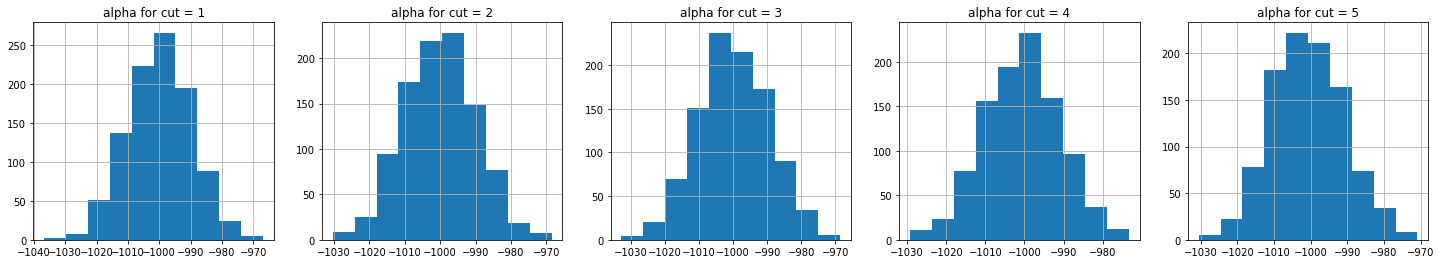

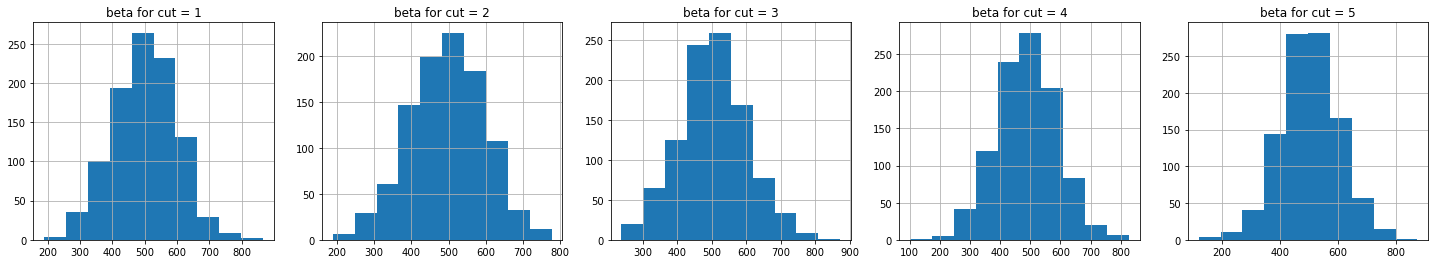

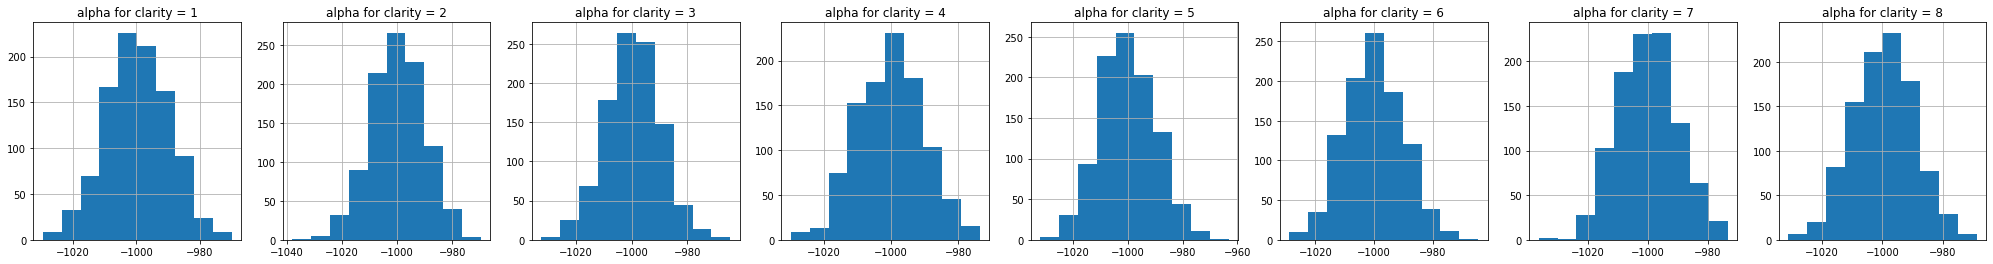

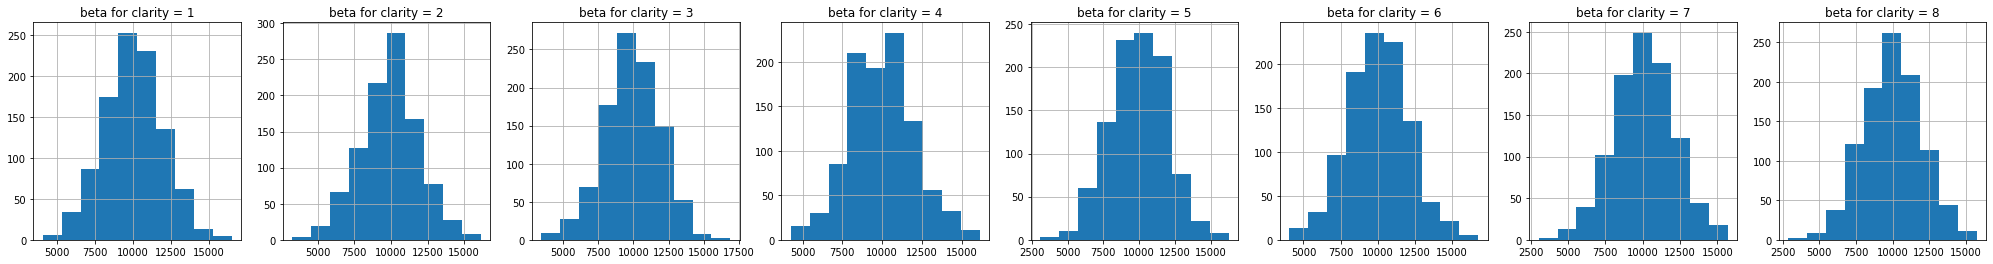

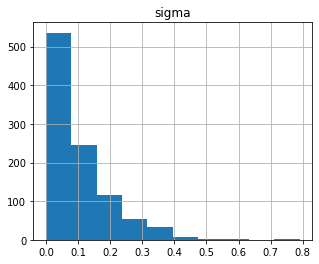

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-999.93,10.15,-1018.83,-981.37
alpha_cut[1],-1000.15,10.11,-1016.77,-980.53
alpha_cut[2],-999.82,10.31,-1018.27,-979.77
alpha_cut[3],-1000.62,9.66,-1017.00,-981.90
alpha_cut[4],-1000.67,9.84,-1017.88,-981.41
beta_cut[0],501.41,98.19,301.54,659.84
beta_cut[1],495.03,100.69,307.68,688.09
beta_cut[2],503.49,97.83,314.95,692.28
beta_cut[3],488.05,101.48,300.60,666.09
beta_cut[4],502.83,100.88,325.59,713.06


In [21]:
alpha_cut_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_cut'))
alpha_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_clarity'))
beta_cut_sim = pd.DataFrame(model_2_sim.stan_variable('beta_cut'))
beta_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('beta_clarity'))
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_2_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_sim[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_sim[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_sim[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_sim[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_sim, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---
### Model 2 - Comparing margin prior values with data
[***Return to table of contents***](#table-of-contents)

---

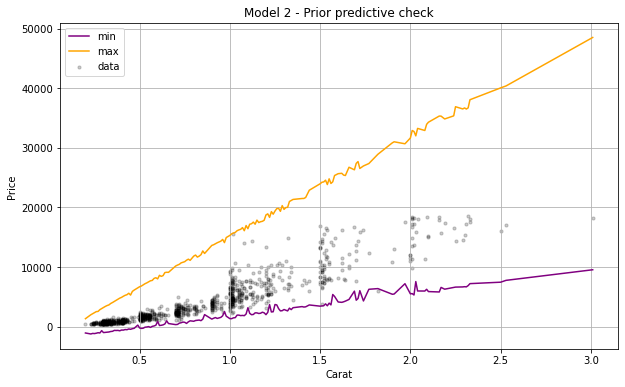

In [22]:
price_sim = model_2_sim.stan_variable('price')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Prior predictive check")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

Based on the shape of obtained cone which contains most of datapoints, it can be concluded that the prior predictive was successful. The obtained lines include points as expected.

---
### Model 2 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

As mentioned previously sampling time was heavily dependent on number of datapoints, but, according to diagnose result, no other issues were encountered.

#### Second model stan code:

![](./images/model_2.png)

---

In [23]:
model_2 = CmdStanModel(stan_file='stanfiles/model_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [24]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_2_fit = model_2.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [25]:
model_2_fit.diagnose()

'Processing csv files: C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_2-20220620203554_1.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_2-20220620203554_2.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_2-20220620203554_3.csv, C:\\Users\\Marcin\\AppData\\Local\\Temp\\tmpv_2un95j\\model_2-20220620203554_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

---

### Model 2 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is indicative of the diamonds in same class being slightly different from one another.
The differences between distributions for each clarity class indicates that each class is modeled differently.

---

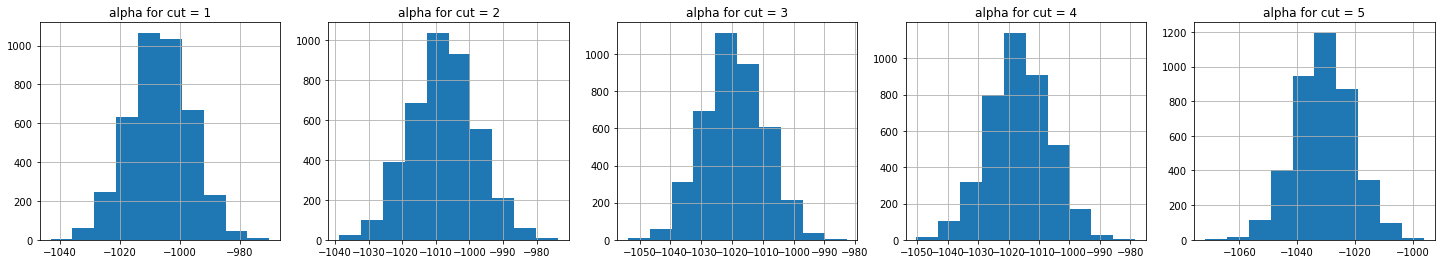

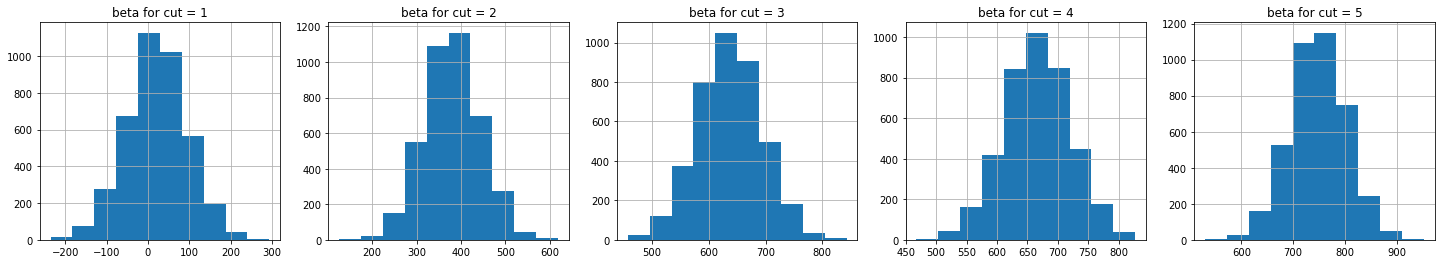

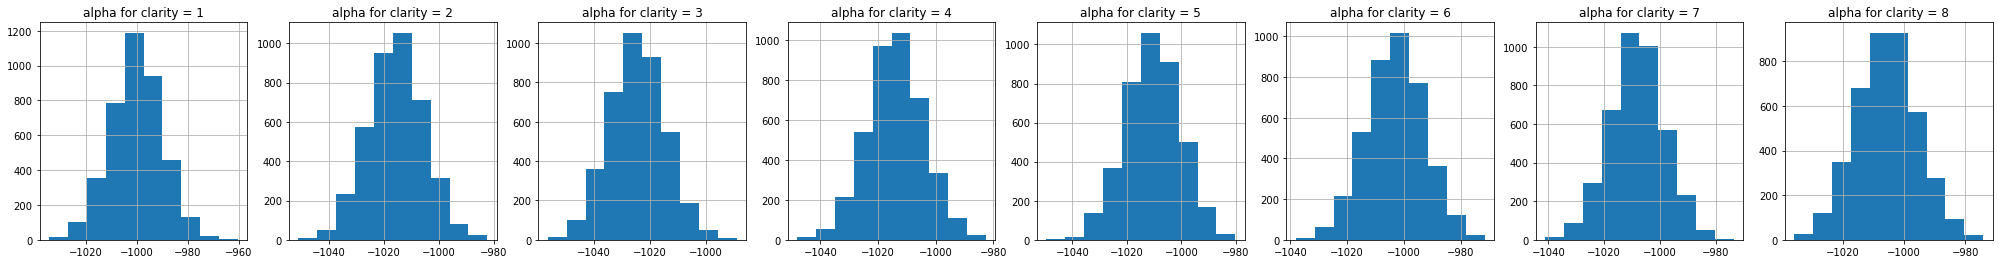

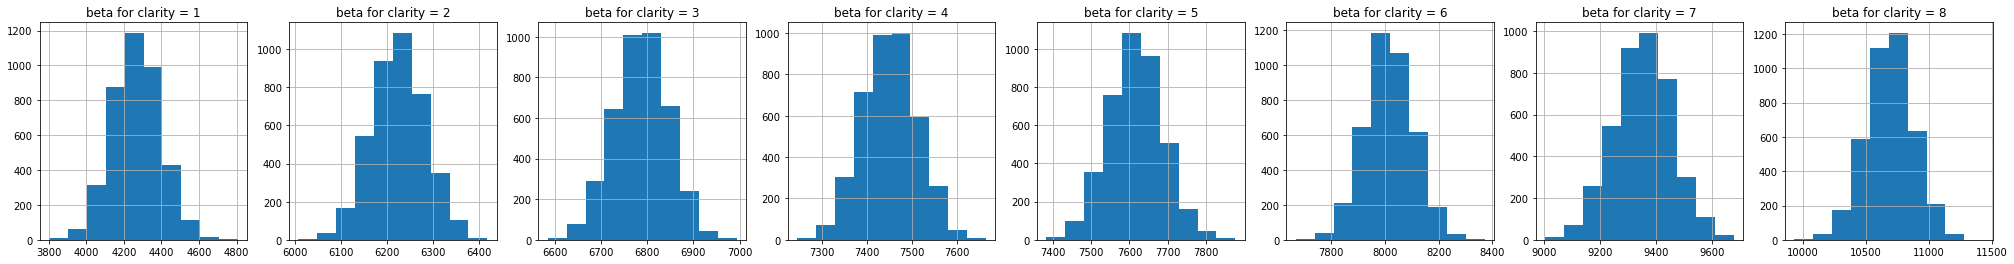

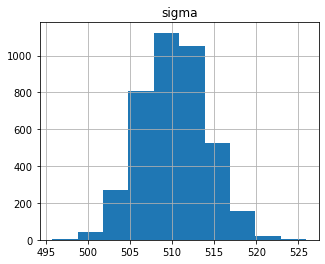

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-1006.57,10.02,-1026.18,-988.79
alpha_cut[1],-1007.73,9.90,-1026.30,-989.60
alpha_cut[2],-1019.23,9.91,-1036.54,-999.95
alpha_cut[3],-1016.55,9.96,-1034.73,-997.11
alpha_cut[4],-1030.81,9.86,-1048.86,-1011.18
beta_cut[0],21.10,73.24,-116.98,158.89
beta_cut[1],380.57,63.17,263.95,501.50
beta_cut[2],636.70,56.57,529.62,740.27
beta_cut[3],666.01,54.91,560.56,768.98
beta_cut[4],747.92,54.16,648.80,851.09


In [26]:
alpha_cut_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_cut'))
alpha_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_clarity'))
beta_cut_fit = pd.DataFrame(model_2_fit.stan_variable('beta_cut'))
beta_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('beta_clarity'))
sigma_fit = model_2_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_fit[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_fit[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_fit[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_fit[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_fit, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---

### Model 2 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 2 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. Most of the simulated diamonds fall within real data ranges.

---

In [27]:
data = model_2_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+34:len(df_trim)+1034]]
#print(price_sims)

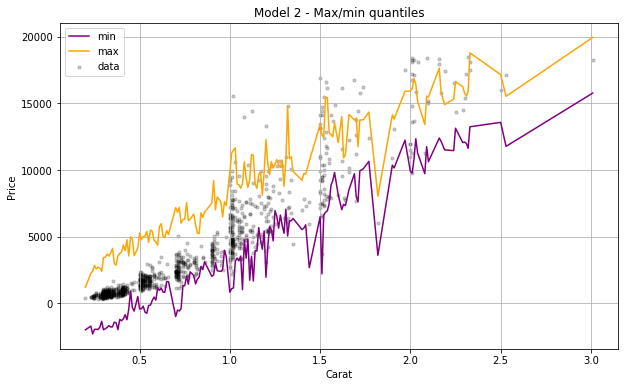

In [28]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Max/min quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

---
#### Model 2 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is slightly better than the first one. 

Predictions seem to be more concentrated around real values while having more true-to-dataset deviation.

---

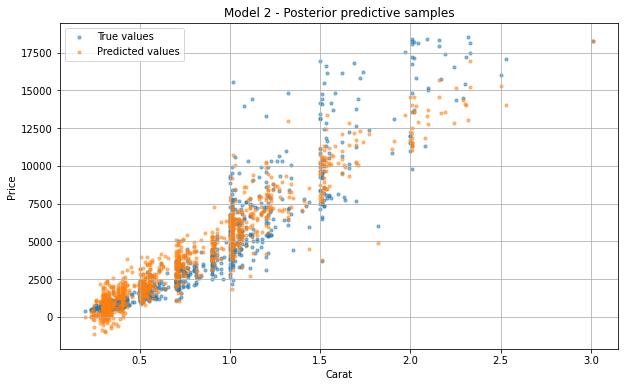

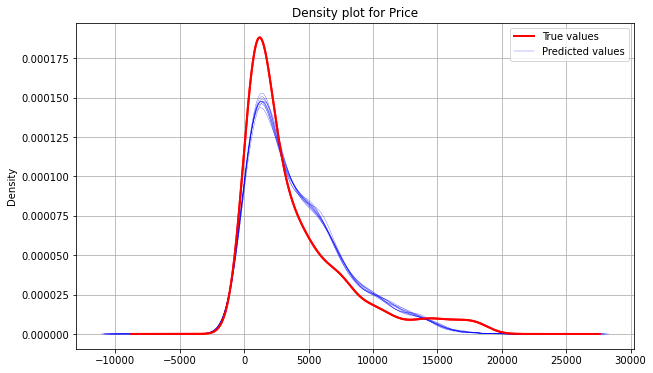

In [29]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[1], alpha=0.5, s=10)
plt.title("Model 2 - Posterior predictive samples")
plt.legend(["True values", "Predicted values"])
plt.xlabel("Carat")
plt.ylabel("Price")
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---

## Model Comparison
[***Return to table of contents***](#table-of-contents)

Leave-one-out cross-validation (LOO) and the widely applicable information criterion (WAIC) are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values. 
The comparison function used allows the models to be assessed against each of these criteria, ordering them from best to worst.

---

### PSIS-LOO Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the PSIS-LOO criterion, it can be concluded that:
* Second model - with three predictors - has lower rank (which means the best model).
* It has higher out-of-sample predictive fit ('loo' column).
* Has higher probability of the correctness of the model ('weight' column).
* Standard error of the difference information criteria between each model and the top ranked model ('dse' column) shows that the differences between the models are small.
* For both models there is a warning that indicates that the computation of the information criteria may not be reliable.

---

e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less 



         rank           loo       p_loo       d_loo    weight          se  \
Model_2     0 -10303.688116  195.438872    0.000000  0.881647  267.326614   
Model_1     1 -10761.135705  143.892582  457.447588  0.118353  261.497517   

               dse  warning loo_scale  
Model_2   0.000000     True       log  
Model_1  55.419562     True       log  


<AxesSubplot:xlabel='Log'>

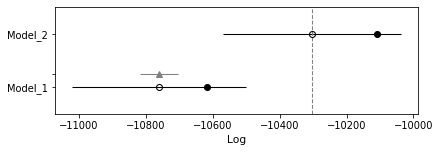

In [30]:
fit_1 = az.from_cmdstanpy(posterior=model_1_fit,
                            log_likelihood="log_lik",
                            posterior_predictive="price_sim",
                            observed_data=df_trim['price'])

fit_2 = az.from_cmdstanpy(posterior=model_2_fit,
                            log_likelihood="log_lik",
                            posterior_predictive="price_sim",
                            observed_data=df_trim['price'])

compare_dict = {"Model_1": fit_1, "Model_2": fit_2}

comp_loo = az.compare(compare_dict, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)

---

### WAIC Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the WAIC criterion, it can be concluded that the conclusions are identical to the previous criterion, i.e.:
* Second model - three predictors - has lower rank (which means the best model).
* It has higher out-of-sample predictive fit ('waic' column).
* Has higher probability of the correctness of the model ('weight' column).
* Standard error of the difference information criteria between each model and the top ranked model ('dse' column) shows that the differences between the models are small.
* For both models there is a warning that indicates that the computation of the information criteria may not be reliable.

---

e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(




         rank          waic      p_waic      d_waic    weight          se  \
Model_2     0 -10303.096594  194.847349    0.000000  0.882781  267.308899   
Model_1     1 -10763.277662  146.034539  460.181068  0.117219  262.041782   

               dse  warning waic_scale  
Model_2   0.000000     True        log  
Model_1  55.493147     True        log  


e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Log'>

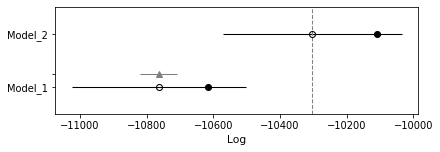

In [31]:
comp_waic = az.compare(compare_dict, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)

---

# Model Comparison - conclusions
[***Return to table of contents***](#table-of-contents)

Comparing the models, both visually and by criteria, we can agree that the model with more predictors fits the real data better, although the differences seem to be small but not insignificant. It is most likely an issue caused by predictor values. As mentioned the clarity and quality were provided merely as a classification that falls within a range of numeric values or subjective grading. Having precise measurements for these predictors could wastly imporve the overall accuracy and provide an insight on predictor's importance in gem pricing.

---